<a href="https://colab.research.google.com/github/Dhruv721725/Extras/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers,models
from sklearn.metrics import confusion_matrix, classification_report
import itertools

print("Tensorflow: ",tf.__version__)

# gpu check
gpus = tf.config.list_physical_devices("GPU")
print("GPU's available: ",gpus)

Tensorflow:  2.19.0
GPU's available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# title @class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# load fashion mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train/255.0).astype("float32")[...,np.newaxis]
x_test = (x_test/255.0).astype("float32")[...,np.newaxis]

print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train:  (60000, 28, 28, 1) (60000,)
Test:  (10000, 28, 28, 1) (10000,)


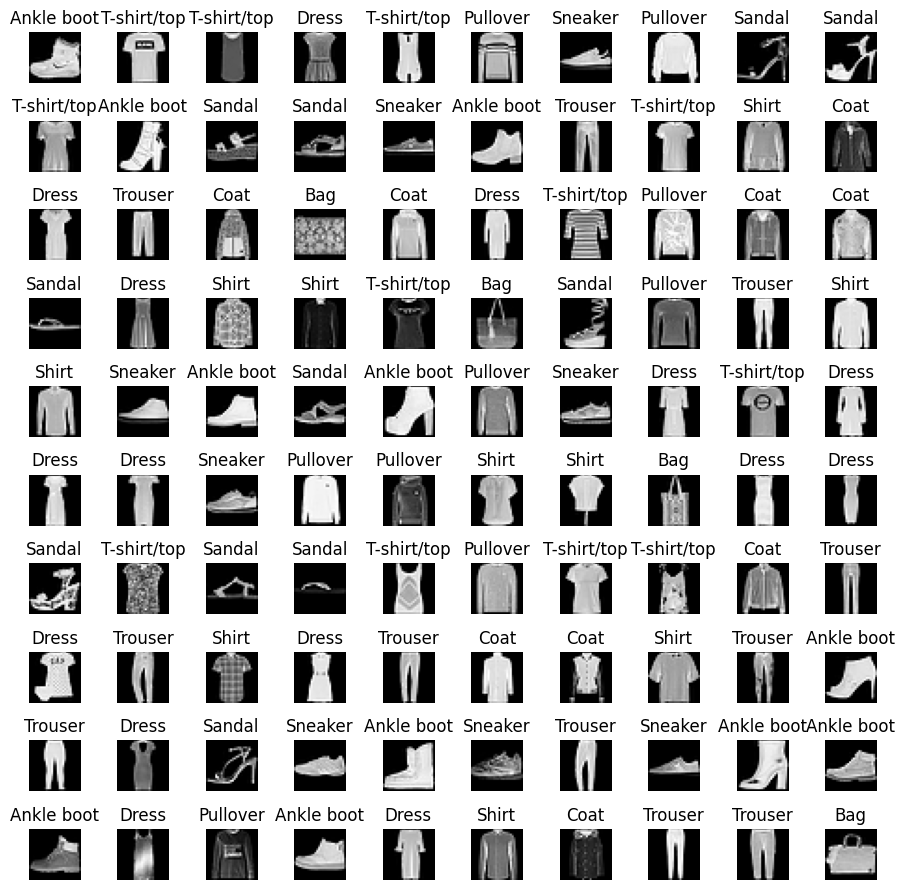

In [ ]:
plt.figure(figsize=(9,9))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(x_train[i].squeeze(),cmap="gray")
  plt.title(class_names[y_train[i]])
  plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
  x_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
print("Train: ", x_tr.shape, y_tr.shape, "| Val:", x_val.shape, y_val.shape)


Train:  (54000, 28, 28, 1) (54000,) | Val: (6000, 28, 28, 1) (6000,)


In [ ]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta = 0.1)
  image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
  return image, label

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))\
  .shuffle(10_000)\
  .map(augment, num_parallel_calls=AUTOTUNE)\
  .batch(batch_size)\
  .prefetch(AUTOTUNE)

ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))\
  .batch(batch_size)\
  .prefetch(AUTOTUNE)

ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))\
  .batch(batch_size)\
  .prefetch(AUTOTUNE)


In [ ]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

inputs = layers.Input(shape=(28,28,1))
x = conv_block(inputs, 32)
x = conv_block(x, 32)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = conv_block(x, 64)
x = conv_block(x, 64)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = conv_block(x, 128)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)  # softmax for class probs

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 288,682 (1.10 MB)

 Trainable params: 288,042 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# @title 🏃 Train with EarlyStopping + LR scheduler
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5, monitor="val_loss"),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.5614 - loss: 1.3000 - val_accuracy: 0.7745 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8051 - loss: 0.5363 - val_accuracy: 0.8725 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8414 - loss: 0.4446 - val_accuracy: 0.8920 - val_loss: 0.2919 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8580 - loss: 0.3904 - val_accuracy: 0.9035 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8737 - loss: 0.3560 - val_accuracy: 0.9053 - val_loss: 0.2593 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8815 - loss: 0.3398 - val_accuracy: 0.8957 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8887 - loss: 

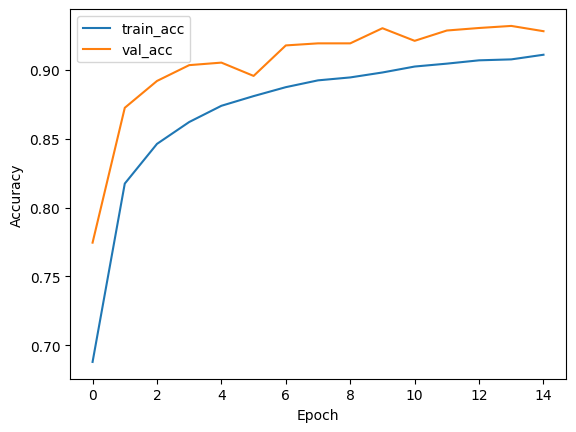

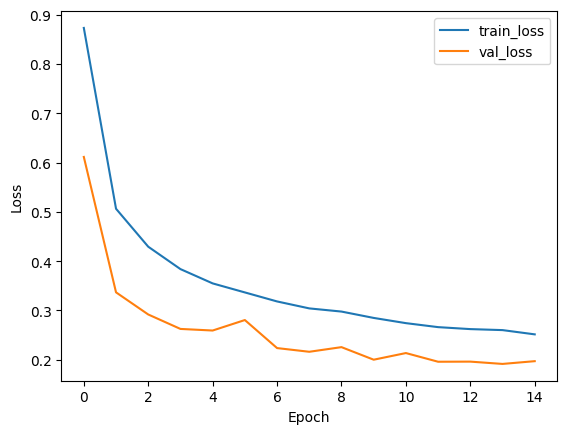

In [ ]:
# @title 📈 Plot training curves
hist = history.history
plt.figure()
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Test accuracy: 0.9214
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion matrix:
 [[905   0  17  18   2   1  55   0   2   0]
 [  0 985   0  12   0   0   1   0   2   0]
 [ 16   1 898   9  32   0  44   0   0   0]
 [ 10   2   8 922  34   0  24   0   0   0]
 [  1   1  39  21 879   0  59   0   0   0]
 [  0   0   0   1   0 973   0  19   0   7]
 [122   1  53  26  57   0 737   0   4   0]
 [  0   0   0   0   0   5   0 984   0  11]
 [  2   1   1   3   1   2   3   2 985   0]
 [  0   0   1   0   0   5   0  48   0 946]]


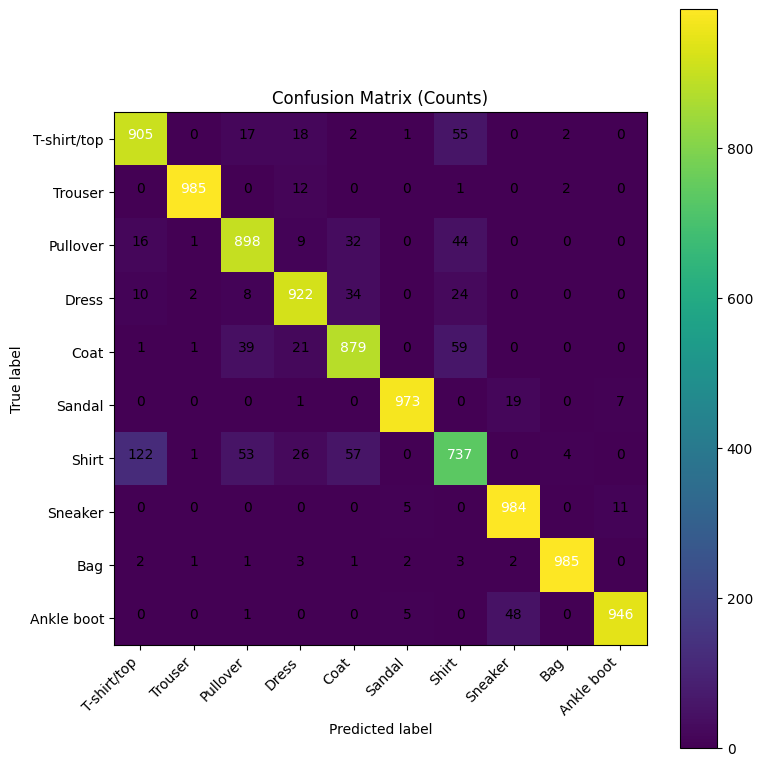

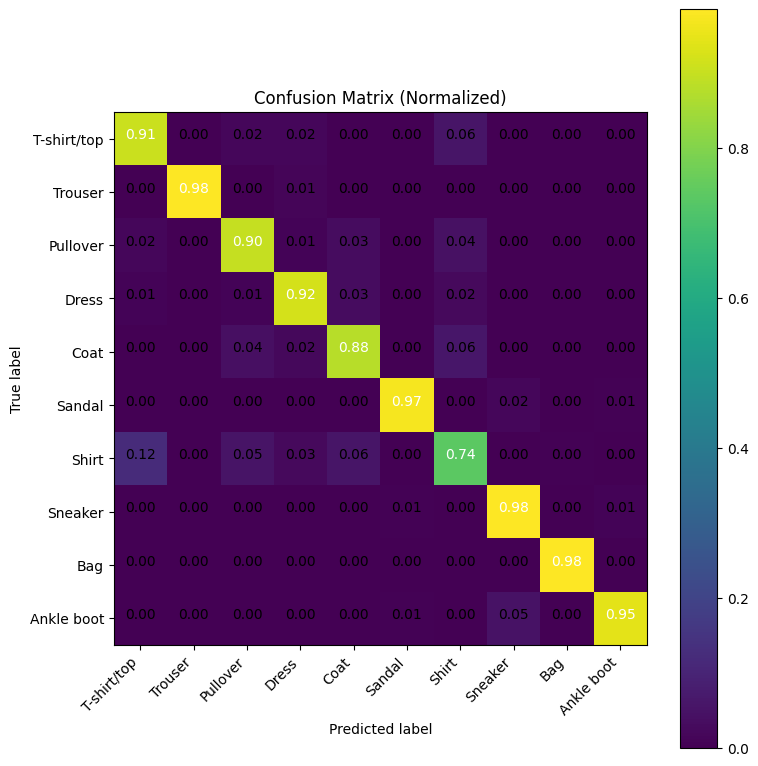


Classification report:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.91      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.90      0.89      1000
       Dress       0.91      0.92      0.92      1000
        Coat       0.87      0.88      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.80      0.74      0.77      1000
     Sneaker       0.93      0.98      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
# @title ✅ Evaluate & Confusion Matrix
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict(ds_test)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix (Normalized)")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
# @title 💾 Save Keras model & labels
model.save("fashion_mnist_cnn.h5")

with open("label_map.txt", "w") as f:
    for i, name in enumerate(class_names):
        f.write(f"{i}:{name}\n")

print("Saved: fashion_mnist_cnn.h5 and label_map.txt")


Saved: fashion_mnist_cnn.h5 and label_map.txt


In [ ]:
# @title 🔄 Convert to TFLite (Dynamic Range Quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # dynamic-range quantization
tflite_model = converter.convert()

with open("fashion_mnist_cnn_dynamic.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: fashion_mnist_cnn_dynamic.tflite")

Saved artifact at '/tmp/tmpzdm5p5nu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134040149056336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149056720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149058832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149058064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149056528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149060176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149057872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149060944

In [ ]:
# @title 🔬 Convert to TFLite (Full Integer INT8 Quantization)
def representative_data_gen():
    for i in range(200):  # few hundred samples are enough
        img = x_tr[i]
        img = np.expand_dims(img, axis=0).astype(np.float32)
        yield [img]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

int8_tflite = converter.convert()
with open("fashion_mnist_cnn_int8.tflite", "wb") as f:
    f.write(int8_tflite)

print("Saved: fashion_mnist_cnn_int8.tflite (full integer)")


Saved artifact at '/tmp/tmpozkiqf3i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134040149056336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149056720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149058832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149058064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149056528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149060176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149059792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149057872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134040149060944

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: fashion_mnist_cnn_int8.tflite (full integer)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


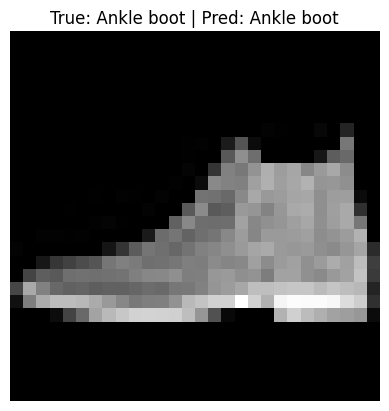

In [ ]:
# @title 🧪 Test TFLite Inference (Dynamic model)
# This test uses the dynamic-quantized TFLite model.
interpreter = tf.lite.Interpreter(model_path="fashion_mnist_cnn_dynamic.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Pick a test image
idx = 0
img = x_test[idx:idx+1]  # shape (1, 28, 28, 1)

# If input type is not float32, cast accordingly
inp_type = input_details[0]['dtype']
img_for_infer = img.astype(inp_type)

interpreter.set_tensor(input_details[0]['index'], img_for_infer)
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]['index'])[0]
pred_class = np.argmax(pred)

plt.imshow(img[0].squeeze(), cmap="gray")
plt.title(f"True: {class_names[y_test[idx]]} | Pred: {class_names[pred_class]}")
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')